# Trabajo práctico integrador - Visión por Computadoras II
## Carrera de Especialización en Inteligencia Artificial - Cohorte 17
### Autores:
* Piñero, Juan Cruz 
* Lloveras, Alejandro
* Méndez, Diego Martín

**Objetivo del trabajo**

Utilizar modelos de *Computer Vision* para clasificar enfermedades de plantas (38 clases).

In [1]:
# Importamos librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Dataset

Dataset de Kaggle con ~87 mil imágenes RGB de hojas de cultivos sanas y enfermas, categorizadas en 38 clases diferentes.

**Link:** https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

print("Path to dataset files:", path)

/opt/anaconda3/envs/cv-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 2.04G/2.04G [01:48<00:00, 20.1MB/s]

Extracting model files...


Path to dataset files: /Users/alejandrolloveras/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/versions/3


## Importación de imágenes

In [3]:
import os
import logging

In [4]:
# CONFIGURACIÓN INICIAL:

# Ruta de acceso al dataset
ROOT_DIR = '/Users/alejandrolloveras/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/versions/3/plantvillage dataset/color'

# Separador usado en los nombres de las subcarpetas
SEPARATOR = '___' # Separa entre 'group' y 'class'

# Extensiones de archivo de imagen a considerar (en minúsculas)
IMAGE_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp'}

# Configuración básica de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [5]:
def process_image_directory(root_dir, separator='___', valid_extensions=None):
    """
    Recorre un directorio raíz, extrae rutas de imágenes y metadatos de subcarpetas.

    Args:
        root_dir (str): La ruta al directorio raíz que contiene las subcarpetas de clases.
        separator (str): El separador utilizado en los nombres de las subcarpetas
                         para dividir 'group' y 'class'.
        valid_extensions (set, optional): Un conjunto de extensiones de archivo (en minúsculas,
                                          incluyendo el punto) a considerar como imágenes.
                                          Si es None, se usará un conjunto predeterminado.

    Returns:
        pandas.DataFrame: Un DataFrame con las columnas 'image_path', 'filename', 'group', 'class'.
                          Retorna un DataFrame vacío si el directorio raíz no existe o
                          no se encuentran imágenes válidas.
    """
    if valid_extensions is None:
        valid_extensions = IMAGE_EXTENSIONS # Verifica que sean archivos de imagen

    data = []
    output_columns = ['image_path', 'filename', 'group', 'class'] # Define la estructura para el Dataframe

    if not os.path.isdir(root_dir):
        logging.error(f"El directorio raíz especificado no existe: {root_dir}")
        return pd.DataFrame(data, columns=output_columns) # Asegura que exista el directorio

    logging.info(f"Comenzando el procesamiento del directorio: {root_dir}")

    # Exploración de cada sucarpeta
    for entry in os.scandir(root_dir):
        if entry.is_dir():
            subdir_name = entry.name
            subdir_path = entry.path
            logging.info(f"Procesando subdirectorio: {subdir_name}")

            if separator in subdir_name:
                try:
                    group_name, class_name = subdir_name.split(separator, 1)
                except ValueError:
                    logging.warning(f"No se pudo dividir el nombre '{subdir_name}' usando '{separator}'. Saltando directorio.")
                    continue

                for sub_entry in os.scandir(subdir_path):
                    if sub_entry.is_file():
                        file_name = sub_entry.name
                        file_path = sub_entry.path

                        _, extension = os.path.splitext(file_name)
                        if extension.lower() in valid_extensions:
                            relative_path = os.path.relpath(os.path.dirname(file_path), root_dir) # Carpeta dónde encontrar a imagen
                            
                            # Almacena toda la información
                            data.append({
                                'image_path': f"{relative_path}/",
                                'filename': file_name,
                                'group': group_name,
                                'class': class_name
                            })
                        else:
                            logging.debug(f"Archivo omitido (no es imagen válida): {file_path}")
            else:
                logging.warning(f"El nombre del subdirectorio '{subdir_name}' no contiene el separador '{separator}'. Saltando.")

    if not data:
        logging.warning("No se encontraron imágenes válidas en la estructura de directorios especificada.")

    # Construye el DataFrame
    df = pd.DataFrame(data, columns=output_columns)
    logging.info(f"Proceso completado. Se encontraron {len(df)} imágenes.")
    return df

In [6]:
df = process_image_directory(ROOT_DIR)

2025-03-31 13:30:15,389 - INFO - Comenzando el procesamiento del directorio: /Users/alejandrolloveras/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/versions/3/plantvillage dataset/color
2025-03-31 13:30:15,397 - INFO - Procesando subdirectorio: Strawberry___healthy
2025-03-31 13:30:15,415 - INFO - Procesando subdirectorio: Grape___Black_rot
2025-03-31 13:30:15,446 - INFO - Procesando subdirectorio: Potato___Early_blight
2025-03-31 13:30:15,473 - INFO - Procesando subdirectorio: Blueberry___healthy
2025-03-31 13:30:15,512 - INFO - Procesando subdirectorio: Corn_(maize)___healthy
2025-03-31 13:30:15,536 - INFO - Procesando subdirectorio: Tomato___Target_Spot
2025-03-31 13:30:15,565 - INFO - Procesando subdirectorio: Peach___healthy
2025-03-31 13:30:15,573 - INFO - Procesando subdirectorio: Potato___Late_blight
2025-03-31 13:30:15,592 - INFO - Procesando subdirectorio: Tomato___Late_blight
2025-03-31 13:30:15,632 - INFO - Procesando subdirectorio: Tomato___Tomato_mosaic_vi

In [7]:
df.sample(5)

,image_path,filename,group,class
48895,Strawberry___Leaf_scorch/,1f7f3e65-fb9f-4a05-8304-26850067d617___RS_L.Sc...,Strawberry,Leaf_scorch
23140,Grape___healthy/,7dcbe0fa-4dc1-4234-97d4-9c19391fbe21___Mt.N.V_...,Grape,healthy
22670,Tomato___Bacterial_spot/,d1c21ca6-efc2-48f3-a1be-1593320db75c___GCREC_B...,Tomato,Bacterial_spot
17190,Orange___Haunglongbing_(Citrus_greening)/,0df51ff0-4618-4eac-ba38-04b7a781294c___CREC_HL...,Orange,Haunglongbing_(Citrus_greening)
34587,Tomato___Tomato_Yellow_Leaf_Curl_Virus/,2ff9d604-2e15-4baa-974d-2038df4501e1___UF.GRC_...,Tomato,Tomato_Yellow_Leaf_Curl_Virus


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54305 entries, 0 to 54304
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  54305 non-null  object
 1   filename    54305 non-null  object
 2   group       54305 non-null  object
 3   class       54305 non-null  object
dtypes: object(4)
memory usage: 1.7+ MB


In [9]:
df.describe()

,image_path,filename,group,class
count,54305,54305,54305,54305
unique,38,54305,14,21
top,Orange___Haunglongbing_(Citrus_greening)/,c7f4b7b2-b13c-476e-a936-c91ce39749a3___RS_HL 6...,Tomato,healthy
freq,5507,1,18160,15084


In [10]:
print("Conteo por grupo:")
print(df['group'].value_counts())

Conteo por grupo:
group
Tomato                     18160
Orange                      5507
Soybean                     5090
Grape                       4062
Corn_(maize)                3852
Apple                       3171
Peach                       2657
Pepper,_bell                2475
Potato                      2152
Cherry_(including_sour)     1906
Squash                      1835
Strawberry                  1565
Blueberry                   1502
Raspberry                    371
Name: count, dtype: int64


In [11]:
print("Conteo por clase:")
print(df['class'].value_counts())

Conteo por clase:
class
healthy                                15084
Haunglongbing_(Citrus_greening)         5507
Bacterial_spot                          5421
Tomato_Yellow_Leaf_Curl_Virus           5357
Late_blight                             2909
                                       ...  
Leaf_Mold                                952
Apple_scab                               630
Cercospora_leaf_spot Gray_leaf_spot      513
Tomato_mosaic_virus                      373
Cedar_apple_rust                         275
Name: count, Length: 21, dtype: int64


## Carga de imágenes

In [ ]:
from PIL import Image
import os
def load_image(data: pd.DataFrame, index: int, root: str=ROOT_DIR):
    """
    Carga una imagen PIL desde una fila específica de un DataFrame.

    Args:
        dataframe (pandas.DataFrame): El DataFrame que contiene las rutas de las imágenes.
        index (int): El índice de la fila en el DataFrame para cargar la imagen.
        root_dir (str): El directorio raíz donde se encuentran las imágenes.

    Returns:
        PIL.Image.Image: La imagen cargada como un objeto PIL.Image, o None si ocurre un error.
    """
    if index < 0 or index >= len(data):
        print("Índice fuera de rango.")
        return None

    row = data.iloc[index]
    relative_path = row['image_path']
    filename = row['filename']
    full_path = os.path.join(root, relative_path, filename)

    try:
        img = Image.open(full_path)
        return img
    except FileNotFoundError:
        print(f"Archivo no encontrado: {full_path}")
        return None
    except Exception as e:
        print(f"Error al cargar la imagen: {e}")
        return None

In [20]:
df

,image_path,filename,group,class
0,Strawberry___healthy/,8f558908-aa1b-4a86-855a-5094c2392e5a___RS_HL 1...,Strawberry,healthy
1,Strawberry___healthy/,b8e9ed27-8e37-4214-9206-f8c0ef21cf4d___RS_HL 4...,Strawberry,healthy
2,Strawberry___healthy/,abdd34a0-ab02-41e0-95a3-a014ab863ec2___RS_HL 1...,Strawberry,healthy
3,Strawberry___healthy/,d1aee44a-b6bb-45b9-b7b6-5d553add8fd1___RS_HL 2...,Strawberry,healthy
4,Strawberry___healthy/,3d28c3ea-8419-4e09-addd-211e3828e39f___RS_HL 1...,Strawberry,healthy
...,...,...,...,...
54300,Soybean___healthy/,57c18b39-2a33-471f-91eb-a9ba4ddabc7b___RS_HL 6...,Soybean,healthy
54301,Soybean___healthy/,4fdc663e-a8ea-4d8a-801b-ef18ad192661___RS_HL 6...,Soybean,healthy
54302,Soybean___healthy/,df807f13-078b-4a6a-9c23-e43e540ecdc2___RS_HL 5...,Soybean,healthy
54303,Soybean___healthy/,60bf9858-951a-4b56-906e-3c1b336973ba___RS_HL 4...,Soybean,healthy


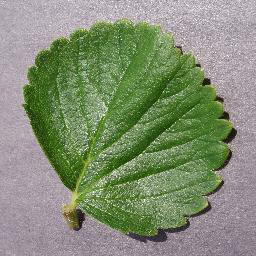

In [41]:
# Permite visualizar una imagen específica (con iloc)
index = 0 # Indice de la imagen a cargar
image = load_image(data=df, index=index, root=ROOT_DIR)

#image.show() #popup option
image

## Dataset split

In [23]:
from sklearn.model_selection import train_test_split

In [ ]:
def split_data(df,
               target_column='class',
               test_size=0.20,
               validation_size=0.0, # Por defecto no define un conjunto de validación
               random_state=42,     # Semilla para reproducibilidad
               split_column_name='split'):
    """
    Añade una columna al DataFrame indicando la división (train/test/validation).

    Realiza una división estratificada para mantener el balance de clases.

    Args:
        df (pd.DataFrame): DataFrame de entrada con al menos la columna 'target_column'.
        target_column (str): Nombre de la columna que contiene las etiquetas de clase
                             para la estratificación (ej: 'class').
        test_size (float): Proporción del dataset a incluir en el conjunto de test (ej: 0.20).
        validation_size (float): Proporción del dataset a incluir en el conjunto de validación.
                                 La proporción de entrenamiento será 1.0 - test_size - validation_size.
                                 Si es 0.0, solo se crearán conjuntos de train y test.
        random_state (int): Semilla para el generador de números aleatorios para asegurar
                            divisiones reproducibles.
        split_column_name (str): Nombre de la nueva columna que contendrá las etiquetas
                                 'train', 'test' o 'validation'.

    Returns:
        pd.DataFrame: El DataFrame original con la nueva columna 'split_column_name'.

    Raises:
        ValueError: Si test_size + validation_size >= 1.0, o si target_column no existe.
        ImportError: Si scikit-learn no está instalado.
    """
    if target_column not in df.columns:
        raise ValueError(f"La columna objetivo '{target_column}' no se encuentra en el DataFrame.")

    if not isinstance(test_size, float) or not (0.0 <= test_size < 1.0):
         raise ValueError("test_size debe ser un float entre 0.0 y 1.0.")

    if not isinstance(validation_size, float) or not (0.0 <= validation_size < 1.0):
         raise ValueError("validation_size debe ser un float entre 0.0 y 1.0.")

    if test_size + validation_size >= 1.0:
        raise ValueError("La suma de test_size y validation_size debe ser menor que 1.0.")

    # Crear la nueva columna inicializada (opcional, pero ayuda a la claridad)
    df[split_column_name] = 'unassigned'

    # Extraer etiquetas para estratificación
    labels = df[target_column]
    indices = df.index # Usaremos los índices para la división

    # --- Lógica de División ---

    # Caso 1: División en Train / Test (sin Validación)
    if validation_size == 0.0:
        train_indices, test_indices = train_test_split(
            indices,
            test_size=test_size,
            random_state=random_state,
            stratify=labels # Permite mantener el balance de clases
        )
        df.loc[train_indices, split_column_name] = 'train'
        df.loc[test_indices, split_column_name] = 'test'
        logging.info(f"División completada: Train ({1-test_size:.1%}), Test ({test_size:.1%}). Estratificada por '{target_column}'.")

    # Caso 2: División en Train / Validation / Test
    else:
        # Paso 1: Dividir en (Train + Validation) y Test
        remaining_indices, test_indices = train_test_split(
            indices,
            test_size=test_size, # Tamaño final del conjunto de test
            random_state=random_state,
            stratify=labels
        )

        # Calcular el tamaño relativo de validación respecto al conjunto restante (Train + Validation)
        # Ejemplo: test=0.2, val=0.1 -> Total 0.3. Restante 0.7. val_rel = 0.1 / 0.7 = 0.142...
        # train_test_split tomará el 14.2% del 70% restante, lo que equivale al 10% del total original.
        relative_val_size = validation_size / (1.0 - test_size)

        # Obtener las etiquetas correspondientes SOLO al conjunto restante para la segunda estratificación
        remaining_labels = df.loc[remaining_indices, target_column]

        # Paso 2: Dividir el conjunto restante en Train y Validation
        train_indices, validation_indices = train_test_split(
            remaining_indices, # Dividir solo los índices restantes
            test_size=relative_val_size, # Tamaño relativo calculado
            random_state=random_state,   # Usar la misma semilla para consistencia
            stratify=remaining_labels    # Estratificar usando las etiquetas restantes
        )

        # Asignar etiquetas de división al DataFrame original
        df.loc[train_indices, split_column_name] = 'train'
        df.loc[validation_indices, split_column_name] = 'valid'
        df.loc[test_indices, split_column_name] = 'test'

        train_actual_prop = len(train_indices) / len(df)
        val_actual_prop = len(validation_indices) / len(df)
        test_actual_prop = len(test_indices) / len(df)
        logging.info(f"División completada: Train ({train_actual_prop:.1%}), Validation ({val_actual_prop:.1%}), Test ({test_actual_prop:.1%}). Estratificada por '{target_column}'.")

    return df

In [36]:
# Disivión del dataset
# (Ejemplo: 70% train, 15% validation, 15% test)
try:
        df_split = split_data(df.copy(), # Usar .copy() para no modificar el original directamente aquí
                                target_column='class',
                                test_size=0.2,
                                validation_size=0.1,
                                random_state=42) # Usa la semilla que prefieras

except ValueError as e:
        print(f"\nError al dividir los datos: {e}")
except ImportError:
        print("\nError: La biblioteca scikit-learn no está instalada. Por favor, instálala con 'pip install scikit-learn'")
except Exception as e:
        print(f"\nOcurrió un error inesperado: {e}")


2025-03-31 13:56:36,504 - INFO - División completada: Train (70.0%), Validation (10.0%), Test (20.0%). Estratificada por 'class'.


In [34]:
df_split.sample(5)

,image_path,filename,group,class,split
27470,Tomato___healthy/,0cabff41-b00b-4692-98af-6b8b0aeba7aa___RS_HL 9...,Tomato,healthy,test
25956,Grape___Esca_(Black_Measles)/,fe2a34b4-5689-499c-a608-adb5d7877c77___FAM_B.M...,Grape,Esca_(Black_Measles),train
27787,Tomato___healthy/,8d3c1a28-27a6-4376-9390-2372dadb7264___GH_HL L...,Tomato,healthy,train
51834,Soybean___healthy/,784c6a81-fbc4-448e-87eb-3f3ea4c435ae___RS_HL 4...,Soybean,healthy,train
34524,Tomato___Tomato_Yellow_Leaf_Curl_Virus/,a8af4da3-a9e0-480a-8a79-781c91cdaa62___UF.GRC_...,Tomato,Tomato_Yellow_Leaf_Curl_Virus,train


In [35]:
print("\n--- Conteo de muestras por 'split' ---")
print(df_split['split'].value_counts(normalize=True)) # normalize=True muestra proporciones

print("\n--- Verificación del Balance de Clases por 'split' ---")

# Comprobar si las proporciones de clases son similares en cada split
print(df_split.groupby('split')['class'].value_counts(normalize=True))


--- Conteo de muestras por 'split' ---
split
train    0.699991
valid    0.150005
test     0.150005
Name: proportion, dtype: float64

--- Verificación del Balance de Clases por 'split' ---
split  class                              
test   healthy                                0.277805
       Haunglongbing_(Citrus_greening)        0.101399
       Bacterial_spot                         0.099804
       Tomato_Yellow_Leaf_Curl_Virus          0.098699
       Late_blight                            0.053523
                                                ...   
valid  Leaf_Mold                              0.017555
       Apple_scab                             0.011539
       Cercospora_leaf_spot Gray_leaf_spot    0.009452
       Tomato_mosaic_virus                    0.006875
       Cedar_apple_rust                       0.005033
Name: proportion, Length: 63, dtype: float64
